In [4]:
import numpy as np
import matplotlib.pyplot as plt
from load_data import get_projections_spacing_radius
from psf_fit import get_psf_kernel
from ipywidgets import interact, widgets
import dill as pickle
import torch
import torch.nn.functional as F
from kornia.geometry.transform import rotate
from torch.nn.functional import interpolate
from scipy.optimize import minimize, curve_fit
from scipy.interpolate import CubicSpline
import pytomography
import torch.nn as nn
from pytomography.utils import pad_object, unpad_object
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import psf_fit2
import importlib
importlib.reload(psf_fit2)
from psf_fit2 import PSFNet
torch.set_default_device('cuda')

In [5]:
ds = [10,15,20,25,30,35,40,45,50,55]
paths = [f'440kev_r{d}' for d in ds]
# Spacing of the theoretical kernel
Nx = 128
dx = 0.24
x_eval = y_eval = np.arange(-(Nx-1)/2, (Nx+1)/2, 1) * dx
projectionss_data = []
projectionss_analytical = []
for path in paths:
    projections_data, dr, distance = get_projections_spacing_radius(path)
    projectionss_data.append(projections_data)
projectionss_data = np.array(projectionss_data)

In [6]:
dr0 = dr

# Part 1: Get Initial Gaussian Parameters For Each Distance

In [7]:
def gaus(x,params):
    params = params.reshape(-1,2)[:,:,np.newaxis,np.newaxis]
    return params[:,0]*np.exp(-x**2/(2*params[:,1]**2))
xv, yv = np.meshgrid(*2*[np.arange(-Nx/2+0.5, Nx/2+0.5, 1)])
rv = np.sqrt(xv**2+yv**2)[np.newaxis]
def loss(params):
    return np.sum((gaus(rv, params) - projectionss_data)**2)

In [8]:
gaus_params_init = np.ones(20)
gaus_params_init[::2] = np.max(projectionss_data, axis=(1,2))

In [9]:
gaus_params_opt = minimize(loss, gaus_params_init).x
gaus_params_opt = gaus_params_opt.reshape(-1,2)

In [10]:
res = gaus(rv,gaus_params_opt)

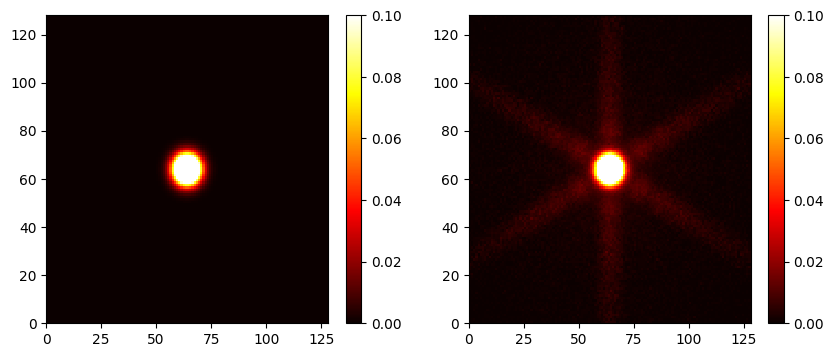

In [11]:
idx = 2
plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(res[idx], cmap='hot', vmax=0.1)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(projectionss_data[idx].T, cmap='hot', vmax=0.1)
plt.colorbar()

# Part 2: Gradient Descent

In [12]:
def gaus(x,params):
    return params[0]*torch.exp(-x**2/(2*params[1]**2))

In [13]:
projectionss_data = torch.tensor(projectionss_data).unsqueeze(1)
xv, yv = torch.meshgrid(*2*[torch.arange(-Nx/2+0.5, Nx/2+0.5, 1)])
rv = torch.sqrt(xv**2+yv**2)
g_params = torch.tensor(gaus_params_opt, requires_grad=True)
g_params.retain_grad()
w = torch.ones(1,1,Nx,requires_grad=True)*0.002
w.retain_grad()
iso = torch.ones(1,1,Nx,requires_grad=True)*0.0002
iso.retain_grad()
scale_factors = np.ones(projectionss_data.shape[0])
amplitudes = np.ones(projectionss_data.shape[0])
SA = np.vstack([scale_factors,amplitudes])

c:\Users\lukep\anaconda3\envs\pytorch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
def fit_func(w, iso, g_params, SA, idx):
    scale_factors = SA.reshape(2,-1)[0]
    amplitudes = SA.reshape(2,-1)[1]
    w_s = amplitudes[idx] * interpolate(w,scale_factor=scale_factors[idx], mode='linear')
    iso_s = amplitudes[idx] * interpolate(iso,scale_factor=scale_factors[idx], mode='linear')
    x = gaus(rv, g_params[idx]).unsqueeze(1)
    y = F.conv1d(x,w_s,padding='same')
    tot = torch.clone(x)
    for i in range(0,3):
        angle = torch.tensor(60*i).to(torch.float)
        tot += rotate(y.unsqueeze(0).swapaxes(1,2), angle, mode='bilinear').swapaxes(1,2).squeeze(0)
    bkg = F.conv1d(x,iso_s,padding='same')
    bkg = F.conv1d(bkg.swapaxes(2,0),iso_s,padding='same').swapaxes(2,0)
    tot+=bkg
    tot = tot.swapaxes(0,1)
    return tot

In [15]:
def train_w(w, iso, g_params, SA, n_iters, lr=1e-3, idx=None):
    for i in range(n_iters):
        if w.grad is not None:
            w.grad.zero_()
        if iso.grad is not None:
            iso.grad.zero_()
        if g_params.grad is not None:
            g_params.grad.zero_()
        error = 0
        for i in range(projectionss_data.shape[0]):
            if idx is not None:
                if i!=idx:
                    continue
            pred = fit_func(w, iso, g_params, SA, i)
            error += torch.sum((pred-projectionss_data[i])**2) + 100*torch.sum(w[w<0]**2) + 10*torch.sum(torch.diff(SA[1,i]*w)**2) + 10*torch.sum(torch.diff(SA[1,i]*iso)**2)
        error.backward()
        w = (w.data - lr * w.grad).requires_grad_(True)
        iso = (iso.data - lr * iso.grad).requires_grad_(True)
        g_params = (g_params.data - lr * g_params.grad).requires_grad_(True)
    return w, iso, g_params

In [16]:
w, iso, g_params = train_w(w, iso, g_params, SA, n_iters=1000, idx=idx)

c:\Users\lukep\anaconda3\envs\pytorch\lib\site-packages\torch\utils\_device.py:62: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return func(*args, **kwargs)


In [17]:
pred = fit_func(w, iso, g_params, SA, idx)

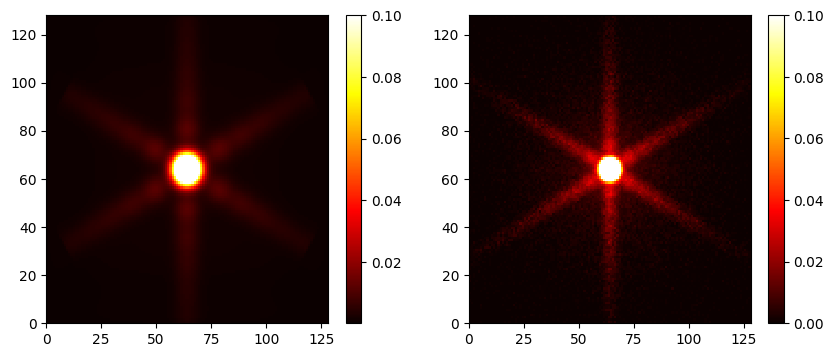

In [20]:
plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(pred[0].cpu().detach().T, cmap='hot', vmax=0.1)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(projectionss_data[0,0].cpu().T, cmap='hot', vmax=0.1)
plt.colorbar()

In [23]:
def loss(SA):
    err = 0
    for i in range(10):
        pred = fit_func(w, iso, g_params, SA, i)
        err += np.sum((pred.detach().cpu().numpy() - projectionss_data[i].detach().cpu().numpy())**2)
    return err

In [24]:
for i in range(10):
    SA = minimize(loss, SA.ravel(), method='COBYLA').x
    SA = SA.reshape(2,-1)
    w, iso, g_params = train_w(w, iso, g_params, SA, n_iters=200, lr=5e-4)

In [25]:
idx = 2
pred2 = fit_func(w, iso, g_params, SA, idx)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

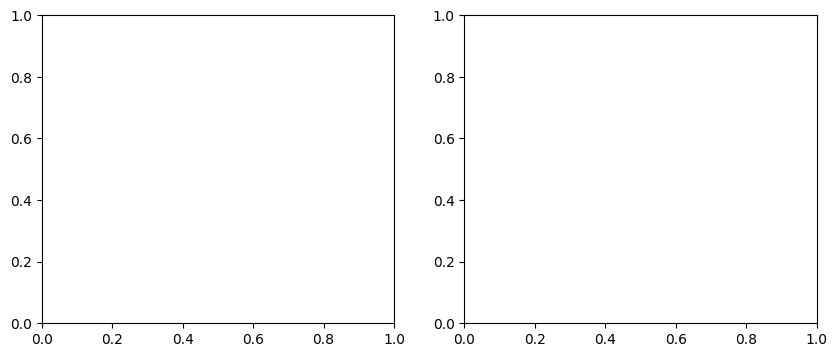

In [26]:
plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(pred2[0].detach().T, cmap='hot', vmax=0.03)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(projectionss_data[idx,0].T, cmap='hot', vmax=0.03)
plt.colorbar()

# Part 3: Fit Sigma/Amplitudes

In [ ]:
distances = np.array(ds)
bkg_amplitude = SA[1]
bkg_sigma = SA[0]
gaus_amplitude = g_params[:,0].detach().numpy()
gaus_sigma = g_params[:,1].detach().numpy()

In [ ]:
def dual_exponential(d, b1, b2, b3, b4):
    return b1*np.exp(-b2*d)+b3*np.exp(-b4*d)

def sqrt_fit(d, b1, b2):
    return b1*d+b2

In [ ]:
gaus_amplitude_fit = curve_fit(dual_exponential, distances, gaus_amplitude)[0]
gaus_sigma_fit = curve_fit(sqrt_fit, distances, gaus_sigma)[0]
bkg_amplitude_fit = curve_fit(dual_exponential, distances, bkg_amplitude)[0]
bkg_sigma_fit = curve_fit(sqrt_fit, distances, bkg_sigma)[0]

In [ ]:
distances_theo = np.linspace(distances.min(), distances.max(), 1000)
gaus_amplitude_theo = dual_exponential(distances_theo, *gaus_amplitude_fit)
gaus_sigma_theo = sqrt_fit(distances_theo, *gaus_sigma_fit)
bkg_amplitude_theo = dual_exponential(distances_theo, *bkg_amplitude_fit)
bkg_sigma_theo = sqrt_fit(distances_theo, *bkg_sigma_fit)

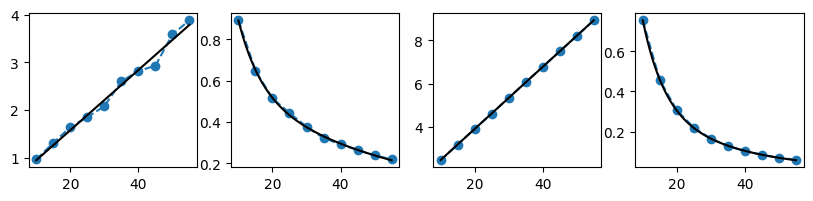

In [ ]:
plt.subplots(1,4,figsize=(10,2))
plt.subplot(141)
plt.plot(distances, bkg_sigma, 'o--')
plt.plot(distances_theo, bkg_sigma_theo, color='k')
plt.subplot(142)
plt.plot(distances, bkg_amplitude, 'o--')
plt.plot(distances_theo, bkg_amplitude_theo, color='k')
plt.subplot(143)
plt.plot(distances, gaus_sigma, 'o--')
plt.plot(distances_theo, gaus_sigma_theo, color='k')
plt.subplot(144)
plt.plot(distances, gaus_amplitude, 'o--')
plt.plot(distances_theo, gaus_amplitude_theo, color='k')
plt.show()

In [ ]:
w_spline_f = CubicSpline(xv[:,0].numpy(), w[0,0].detach().numpy(), extrapolate=False)
iso_spline_f = CubicSpline(xv[:,0].numpy(), iso[0,0].detach().numpy(), extrapolate=False)

In [ ]:
import psf_fit2
import importlib
importlib.reload(psf_fit2)
from psf_fit2 import PSFNet

In [ ]:
psf_net = PSFNet(gaus_amplitude_fit, gaus_sigma_fit, bkg_amplitude_fit, bkg_sigma_fit, w_spline_f, iso_spline_f, dr0)

In [ ]:
with open('psf_net.pkl', 'wb') as f:
    pickle.dump(psf_net, f)

--------------

In [ ]:
pytomography.device = 'cuda'

In [ ]:
def compute_pad_size(width):
    a = (np.sqrt(2) - 1)/2
    if width%2==0:
        width_old = int(2*np.floor((width/2)/(1+2*a)))
    else:
        width_old = int(2*np.floor(((width-1)/2)/(1+2*a)))
    return int((width-width_old)/2)

In [ ]:
# Define distances
size = 128
pad_size = size + 2*int(np.ceil((np.sqrt(2)*size - size)/2)) 
distances_test = np.linspace(66,1,pad_size)*0 + 10
dr = 0.12
kernel_size = 128
with open('psf_net.pkl', 'rb') as f:
    psf_net = pickle.load(f)
psf_net.configure(distances_test, dr, kernel_size)

In [ ]:
x = torch.zeros((1,size,size,size)).to(pytomography.device)
x[:,10:118,62:63,62:63] = 1
x = pad_object(x)

In [ ]:
rr = psf_net(x)

In [ ]:
rr = unpad_object(rr)

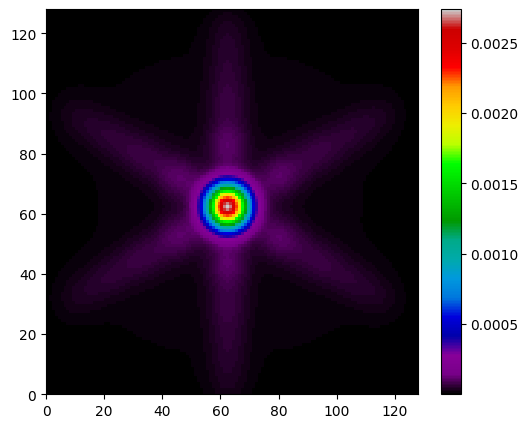

In [ ]:
plt.figure(figsize=(6,5))
plt.pcolormesh(rr[0,34].cpu().detach().T, cmap='nipy_spectral')
plt.colorbar()